# Clustering

In [1]:
from google.colab import files
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/MyDrive/해커톤3/모델 검증_토이데이터_211010"
book_path = file_path + '/goodreads_books_poetry.json.gz'

book = pd.read_json(book_path, lines=True, compression='gzip')

In [4]:
book

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,,1,[],US,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",,false,3.83,,[],Number 30 in a series of literary pamphlets pu...,Paperback,https://www.goodreads.com/book/show/16037549-v...,"[{'author_id': '15585', 'role': ''}]","Houghton, Mifflin and Company",80,1,,11,,1887,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,3,5212748,Vision of Sir Launfal and Other Poems,Vision of Sir Launfal and Other Poems
1,0811223981,2,[],US,,"[{'count': '100', 'name': 'to-read'}, {'count'...",,false,3.83,B00U2WY9U8,[],Fairy Tales gathers the unconventional verse d...,Paperback,https://www.goodreads.com/book/show/22466716-f...,"[{'author_id': '16073', 'role': ''}, {'author_...",New Directions,128,20,9780811223980,4,,2015,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,37,41905435,Fairy Tales: Dramolettes,Fairy Tales: Dramolettes
2,0374428115,7,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,4.38,,[],Three poems describe the nighttime adventures ...,Paperback,https://www.goodreads.com/book/show/926662.Gro...,"[{'author_id': '18540', 'role': ''}, {'author_...",Farrar Straus Giroux,,12,9780374428112,7,,2008,https://www.goodreads.com/book/show/926662.Gro...,https://s.gr-assets.com/assets/nophoto/book/11...,926662,45,911665,Growltiger's Last Stand and Other Poems,Growltiger's Last Stand and Other Poems
3,0156182890,12,[],US,,"[{'count': '554', 'name': 'to-read'}, {'count'...",,false,3.71,B00IWTRB1W,"[1230072, 315167, 676169, 18522, 124335, 88263...",A modern verse play about the search for meani...,Paperback,https://www.goodreads.com/book/show/926667.The...,"[{'author_id': '18540', 'role': ''}]",Mariner Books,190,18,9780156182898,3,,1964,https://www.goodreads.com/book/show/926667.The...,https://images.gr-assets.com/books/1382939971m...,926667,115,995066,The Cocktail Party,The Cocktail Party
4,1942004192,4,[],US,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",,false,5.00,,"[25869488, 23630890, 25448131, 25464039, 42166...",Louder Than Everything You Love is about trans...,Paperback,https://www.goodreads.com/book/show/29065952-l...,"[{'author_id': '14308759', 'role': ''}]",ELJ Publications,118,23,9781942004196,12,First,2015,https://www.goodreads.com/book/show/29065952-l...,https://images.gr-assets.com/books/1455198396m...,29065952,9,49294781,Louder Than Everything You Love,Louder Than Everything You Love
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36509,,1,[],US,eng,"[{'count': '2', 'name': 'poetry'}, {'count': '...",B004CYF8NY,true,5.00,,[],Appetizers\n*Poetry- Acrostic\nWo(Man)- Diaman...,,https://www.goodreads.com/book/show/9874488-ta...,"[{'author_id': '4502880', 'role': ''}]",,,,,,,,https://www.goodreads.com/book/show/9874488-ta...,https://s.gr-assets.com/assets/nophoto/book/11...,9874488,1,14766173,Take Out from the Writer's Café,Take Out from the Writer's Café
36510,,1,[714239],US,,"[{'count': '1158', 'name': 'to-read'}, {'count...",B002LIT2S0,true,3.65,B004UK2JO6,"[1413520, 2212982, 1294378, 1240904, 1693449, ...","There was an Old Derry down Derry, who loved t...",,https://www.goodreads.com/book/show/7657489-a-...,"[{'author_id': '142', 'role': ''}]",,288,,,,,,https://www.goodreads.com/book/show/7657489-a-...,https://s.gr-assets.com/assets/nophoto/book/11...,7657489,3,854054,A Book of Nonsense,A Book of Nonsense
36511,0879230789,1,[],US,,"[{'count': '3', 'name': 'poetry'}]",,false,3.50,,[],,,https://www.goodreads.com/book/show/3762261-su...,"[{'author_id': '1023504', 'role': ''}]",,,,97808792

### 데이터 전처리

#### 공백 -> NAN

In [5]:
book = book.replace(r'^\s*$', np.nan, regex=True)

In [6]:
book.isnull().sum()

isbn                     9980
text_reviews_count          0
series                      0
country_code                0
language_code           19462
popular_shelves             0
asin                    34644
is_ebook                    0
average_rating              0
kindle_asin             26879
similar_books               0
description              7526
format                   7025
link                        0
authors                     0
publisher                6033
num_pages                7505
publication_day         14956
isbn13                   8155
publication_month       13020
edition_information     33089
publication_year         5816
url                         0
image_url                   0
book_id                     0
ratings_count               0
work_id                     0
title                       2
title_without_series        2
dtype: int64

데이터 확인

In [7]:
book.popular_shelves[0][0].items()

dict_items([('count', '8'), ('name', 'to-read')])

In [8]:
book.authors[0][0].items()

dict_items([('author_id', '15585'), ('role', '')])

country code 전부 US -> 제거

In [9]:
set(book.country_code)

{'US'}

In [10]:
book_data = book.drop(['isbn', 'series','country_code', 'language_code','asin','kindle_asin','description', 'publication_day','isbn13', 'publication_month', 'edition_information', 'work_id','publisher'], axis=1)

In [11]:
book_data

,text_reviews_count,popular_shelves,is_ebook,average_rating,similar_books,format,link,authors,num_pages,publication_year,url,image_url,book_id,ratings_count,title,title_without_series
0,1,"[{'count': '8', 'name': 'to-read'}, {'count': ...",false,3.83,[],Paperback,https://www.goodreads.com/book/show/16037549-v...,"[{'author_id': '15585', 'role': ''}]",80,1887,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,3,Vision of Sir Launfal and Other Poems,Vision of Sir Launfal and Other Poems
1,2,"[{'count': '100', 'name': 'to-read'}, {'count'...",false,3.83,[],Paperback,https://www.goodreads.com/book/show/22466716-f...,"[{'author_id': '16073', 'role': ''}, {'author_...",128,2015,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,37,Fairy Tales: Dramolettes,Fairy Tales: Dramolettes
2,7,"[{'count': '32', 'name': 'to-read'}, {'count':...",false,4.38,[],Paperback,https://www.goodreads.com/book/show/926662.Gro...,"[{'author_id': '18540', 'role': ''}, {'author_...",NaN,2008,https://www.goodreads.com/book/show/926662.Gro...,https://s.gr-assets.com/assets/nophoto/book/11...,926662,45,Growltiger's Last Stand and Other Poems,Growltiger's Last Stand and Other Poems
3,12,"[{'count': '554', 'name': 'to-read'}, {'count'...",false,3.71,"[1230072, 315167, 676169, 18522, 124335, 88263...",Paperback,https://www.goodreads.com/book/show/926667.The...,"[{'author_id': '18540', 'role': ''}]",190,1964,https://www.goodreads.com/book/show/926667.The...,https://images.gr-assets.com/books/1382939971m...,926667,115,The Cocktail Party,The Cocktail Party
4,4,"[{'count': '228', 'name': 'to-read'}, {'count'...",false,5.00,"[25869488, 23630890, 25448131, 25464039, 42166...",Paperback,https://www.goodreads.com/book/show/29065952-l...,"[{'author_id': '14308759', 'role': ''}]",118,2015,https://www.goodreads.com/book/show/29065952-l...,https://images.gr-assets.com/books/1455198396m...,29065952,9,Louder Than Everything You Love,Louder Than Everything You Love
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36509,1,"[{'count': '2', 'name': 'poetry'}, {'count': '...",true,5.00,[],NaN,https://www.goodreads.com/book/show/9874488-ta...,"[{'author_id': '4502880', 'role': ''}]",NaN,NaN,https://www.goodreads.com/book/show/9874488-ta...,https://s.gr-assets.com/assets/nophoto/book/11...,9874488,1,Take Out from the Writer's Café,Take Out from the Writer's Café
36510,1,"[{'count': '1158', 'name': 'to-read'}, {'count...",true,3.65,"[1413520, 2212982, 1294378, 1240904, 1693449, ...",NaN,https://www.goodreads.com/book/show/7657489-a-...,"[{'author_id': '142', 'role': ''}]",288,NaN,https://www.goodreads.com/book/show/7657489-a-...,https://s.gr-assets.com/assets/nophoto/book/11...,7657489,3,A Book of Nonsense,A Book of Nonsense
36511,1,"[{'count': '3', 'name': 'poetry'}]",false,3.50,[],NaN,https://www.goodreads.com/book/show/3762261-su...,"[{'author_id': '1023504', 'role': ''}]",NaN,NaN,https://www.goodreads.com/book/show/3762261-su...,https://s.gr-assets.com/assets/nophoto/book/11...,3762261,2,Sunbelly (Number 2 in the First Godine Poetry ...,Sunbelly (Number 2 in the First Godine Poetry ...
36512,4,"[{'count': '247044', 'name': 'to-read'}, {'cou...",false,3.73,"[12914, 904843, 235719, 279456, 1536, 27417, 1...",NaN,https://www.goodreads.com/book/show/23452091-o...,"[{'author_id': '903', 'role': ''}]",487,2013,https://www.goodreads.com/book/show/23452091-o...,https://images.gr-assets.com/books/1414353152m...,23452091,55,Odisea,Odisea


In [12]:
book_data.isnull().sum()

text_reviews_count         0
popular_shelves            0
is_ebook                   0
average_rating             0
similar_books              0
format                  7025
link                       0
authors                    0
num_pages               7505
publication_year        5816
url                        0
image_url                  0
book_id                    0
ratings_count              0
title                      2
title_without_series       2
dtype: int64

maximum recursion depth exceeded in comparison 주의

In [13]:
book_data = book_data.dropna(how='any')

In [14]:
book_data

,text_reviews_count,popular_shelves,is_ebook,average_rating,similar_books,format,link,authors,num_pages,publication_year,url,image_url,book_id,ratings_count,title,title_without_series
0,1,"[{'count': '8', 'name': 'to-read'}, {'count': ...",false,3.83,[],Paperback,https://www.goodreads.com/book/show/16037549-v...,"[{'author_id': '15585', 'role': ''}]",80,1887,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,3,Vision of Sir Launfal and Other Poems,Vision of Sir Launfal and Other Poems
1,2,"[{'count': '100', 'name': 'to-read'}, {'count'...",false,3.83,[],Paperback,https://www.goodreads.com/book/show/22466716-f...,"[{'author_id': '16073', 'role': ''}, {'author_...",128,2015,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,37,Fairy Tales: Dramolettes,Fairy Tales: Dramolettes
3,12,"[{'count': '554', 'name': 'to-read'}, {'count'...",false,3.71,"[1230072, 315167, 676169, 18522, 124335, 88263...",Paperback,https://www.goodreads.com/book/show/926667.The...,"[{'author_id': '18540', 'role': ''}]",190,1964,https://www.goodreads.com/book/show/926667.The...,https://images.gr-assets.com/books/1382939971m...,926667,115,The Cocktail Party,The Cocktail Party
4,4,"[{'count': '228', 'name': 'to-read'}, {'count'...",false,5.00,"[25869488, 23630890, 25448131, 25464039, 42166...",Paperback,https://www.goodreads.com/book/show/29065952-l...,"[{'author_id': '14308759', 'role': ''}]",118,2015,https://www.goodreads.com/book/show/29065952-l...,https://images.gr-assets.com/books/1455198396m...,29065952,9,Louder Than Everything You Love,Louder Than Everything You Love
5,1,"[{'count': '1208', 'name': 'to-read'}, {'count...",false,4.09,"[15796750, 1504664, 138241, 254039, 92852, 419...",Paperback,https://www.goodreads.com/book/show/35235890-s...,"[{'author_id': '11563', 'role': ''}, {'author_...",128,2017,https://www.goodreads.com/book/show/35235890-s...,https://images.gr-assets.com/books/1495907022m...,35235890,4,Su Seviyesi,Su Seviyesi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36505,2,"[{'count': '7', 'name': 'to-read'}, {'count': ...",false,4.89,[],Paperback,https://www.goodreads.com/book/show/28923923-ark,"[{'author_id': '151532', 'role': ''}]",88,2016,https://www.goodreads.com/book/show/28923923-ark,https://images.gr-assets.com/books/1461461459m...,28923923,9,Ark,Ark
36506,1,"[{'count': '3', 'name': 'to-read'}, {'count': ...",false,3.43,[],Hardcover,https://www.goodreads.com/book/show/18456727-n...,"[{'author_id': '2824444', 'role': ''}]",64,1984,https://www.goodreads.com/book/show/18456727-n...,https://images.gr-assets.com/books/1378309388m...,18456727,14,Naše paní Božena Němcová,Naše paní Božena Němcová
36507,6,"[{'count': '29', 'name': 'to-read'}, {'count':...",false,3.48,[],Paperback,https://www.goodreads.com/book/show/557769.Ero...,"[{'author_id': '7202219', 'role': ''}]",96,2001,https://www.goodreads.com/book/show/557769.Ero...,https://s.gr-assets.com/assets/nophoto/book/11...,557769,38,Erotikon: Poems,Erotikon: Poems
36508,9,"[{'count': '3664', 'name': 'to-read'}, {'count...",false,4.09,"[166350, 3018318, 6054142, 5886412, 11296693, ...",Paperback,https://www.goodreads.com/book/show/7136006,"[{'author_id': '6466154', 'role': ''}]",93,1982,https://www.goodreads.com/book/show/7136006,https://images.gr-assets.com/books/1289296805m...,7136006,55,رمل وزبد,رمل وزبد


In [15]:
book_data.isnull().sum()

text_reviews_count      0
popular_shelves         0
is_ebook                0
average_rating          0
similar_books           0
format                  0
link                    0
authors                 0
num_pages               0
publication_year        0
url                     0
image_url               0
book_id                 0
ratings_count           0
title                   0
title_without_series    0
dtype: int64

In [16]:
book_data['is_series'] = book_data['title'] == book_data['title_without_series']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
set(book_data['is_series'])

{True}

In [18]:
book_unique = book_data[['link','url','image_url','book_id','title','authors','popular_shelves','similar_books']]

In [19]:
book_unique

,link,url,image_url,book_id,title,authors,popular_shelves,similar_books
0,https://www.goodreads.com/book/show/16037549-v...,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,Vision of Sir Launfal and Other Poems,"[{'author_id': '15585', 'role': ''}]","[{'count': '8', 'name': 'to-read'}, {'count': ...",[]
1,https://www.goodreads.com/book/show/22466716-f...,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,Fairy Tales: Dramolettes,"[{'author_id': '16073', 'role': ''}, {'author_...","[{'count': '100', 'name': 'to-read'}, {'count'...",[]
3,https://www.goodreads.com/book/show/926667.The...,https://www.goodreads.com/book/show/926667.The...,https://images.gr-assets.com/books/1382939971m...,926667,The Cocktail Party,"[{'author_id': '18540', 'role': ''}]","[{'count': '554', 'name': 'to-read'}, {'count'...","[1230072, 315167, 676169, 18522, 124335, 88263..."
4,https://www.goodreads.com/book/show/29065952-l...,https://www.goodreads.com/book/show/29065952-l...,https://images.gr-assets.com/books/1455198396m...,29065952,Louder Than Everything You Love,"[{'author_id': '14308759', 'role': ''}]","[{'count': '228', 'name': 'to-read'}, {'count'...","[25869488, 23630890, 25448131, 25464039, 42166..."
5,https://www.goodreads.com/book/show/35235890-s...,https://www.goodreads.com/book/show/35235890-s...,https://images.gr-assets.com/books/1495907022m...,35235890,Su Seviyesi,"[{'author_id': '11563', 'role': ''}, {'author_...","[{'count': '1208', 'name': 'to-read'}, {'count...","[15796750, 1504664, 138241, 254039, 92852, 419..."
...,...,...,...,...,...,...,...,...
36505,https://www.goodreads.com/book/show/28923923-ark,https://www.goodreads.com/book/show/28923923-ark,https://images.gr-assets.com/books/1461461459m...,28923923,Ark,"[{'author_id': '151532', 'role': ''}]","[{'count': '7', 'name': 'to-read'}, {'count': ...",[]
36506,https://www.goodreads.com/book/show/18456727-n...,https://www.goodreads.com/book/show/18456727-n...,https://images.gr-assets.com/books/1378309388m...,18456727,Naše paní Božena Němcová,"[{'author_id': '2824444', 'role': ''}]","[{'count': '3', 'name': 'to-read'}, {'count': ...",[]
36507,https://www.goodreads.com/book/show/557769.Ero...,https://www.goodreads.com/book/show/557769.Ero...,https://s.gr-assets.com/assets/nophoto/book/11...,557769,Erotikon: Poems,"[{'author_id': '7202219', 'role': ''}]","[{'count': '29', 'name': 'to-read'}, {'count':...",[]
36508,https://www.goodreads.com/book/show/7136006,https://www.goodreads.com/book/show/7136006,https://images.gr-assets.com/books/1289296805m...,7136006,رمل وزبد,"[{'author_id': '6466154', 'role': ''}]","[{'count': '3664', 'name': 'to-read'}, {'count...","[166350, 3018318, 6054142, 5886412, 11296693, ..."


In [20]:
book_data = book_data.drop(['link','url','image_url','authors','title_without_series','is_series','popular_shelves','similar_books'],axis=1)
book_data

,text_reviews_count,is_ebook,average_rating,format,num_pages,publication_year,book_id,ratings_count,title
0,1,false,3.83,Paperback,80,1887,16037549,3,Vision of Sir Launfal and Other Poems
1,2,false,3.83,Paperback,128,2015,22466716,37,Fairy Tales: Dramolettes
3,12,false,3.71,Paperback,190,1964,926667,115,The Cocktail Party
4,4,false,5.00,Paperback,118,2015,29065952,9,Louder Than Everything You Love
5,1,false,4.09,Paperback,128,2017,35235890,4,Su Seviyesi
...,...,...,...,...,...,...,...,...,...
36505,2,false,4.89,Paperback,88,2016,28923923,9,Ark
36506,1,false,3.43,Hardcover,64,1984,18456727,14,Naše paní Božena Němcová
36507,6,false,3.48,Paperback,96,2001,557769,38,Erotikon: Poems
36508,9,false,4.09,Paperback,93,1982,7136006,55,رمل وزبد


#### 겹치는 values가 많다.

In [21]:
set(book_data['format'].values)

{'10X18',
 'Artist Book',
 'Audible Audio',
 'Audio',
 'Audio CD',
 'Audio Cassette',
 'Audiobook',
 'Bia mem',
 'Board Book',
 'Board book',
 'Bookpaper',
 'Broche',
 'Brochura',
 'CD-ROM',
 'Casebound',
 'Chapbook',
 'Chapbook (Machine Stitched)',
 'Chapbook/Pamphlet',
 'Comic',
 'Danskt band',
 'E-chap',
 'E-chapbook',
 'Electronic Chapbook',
 'Flexibler Einband',
 'HB',
 'HC',
 'Hand-sewn Binding',
 'Handmade Chapbook',
 'Handmade chapbook',
 'Hard Cover',
 'Hardback',
 'Hardback, cloth',
 'Hardcover',
 'Hardcover + CD rom',
 'Hardcover / glyngwr - jyby',
 'Hardcover / glyngwr - wzyry',
 'Hardcover Art and Poetry Gift Book',
 'Hardcover and Paperback',
 'Hardcover first edition',
 'Hardcover glyngwr',
 'Hardcover, Sewn Binding, Paper Dust Jacket',
 'Hardcover/Paperback',
 'Heftet',
 'Journal',
 'Kindle Edition',
 'Leather Bound',
 'Letterpressed Chapbook',
 'Library Binding',
 'Limited Edition Hand-Stitched Chapbook',
 'Livro de papel',
 'MP3 Book',
 'Magazine',
 'Mass Market Paper

In [22]:
book_data['is_ebook'] = book_data['is_ebook'].apply(lambda x : 1 if x=='true' else 0)
book_data

,text_reviews_count,is_ebook,average_rating,format,num_pages,publication_year,book_id,ratings_count,title
0,1,0,3.83,Paperback,80,1887,16037549,3,Vision of Sir Launfal and Other Poems
1,2,0,3.83,Paperback,128,2015,22466716,37,Fairy Tales: Dramolettes
3,12,0,3.71,Paperback,190,1964,926667,115,The Cocktail Party
4,4,0,5.00,Paperback,118,2015,29065952,9,Louder Than Everything You Love
5,1,0,4.09,Paperback,128,2017,35235890,4,Su Seviyesi
...,...,...,...,...,...,...,...,...,...
36505,2,0,4.89,Paperback,88,2016,28923923,9,Ark
36506,1,0,3.43,Hardcover,64,1984,18456727,14,Naše paní Božena Němcová
36507,6,0,3.48,Paperback,96,2001,557769,38,Erotikon: Poems
36508,9,0,4.09,Paperback,93,1982,7136006,55,رمل وزبد


#### 클러스터링에 사용될 데이터셋

In [23]:
book_cluster = book_data.drop(['format','book_id','title'],axis=1)
book_cluster

,text_reviews_count,is_ebook,average_rating,num_pages,publication_year,ratings_count
0,1,0,3.83,80,1887,3
1,2,0,3.83,128,2015,37
3,12,0,3.71,190,1964,115
4,4,0,5.00,118,2015,9
5,1,0,4.09,128,2017,4
...,...,...,...,...,...,...
36505,2,0,4.89,88,2016,9
36506,1,0,3.43,64,1984,14
36507,6,0,3.48,96,2001,38
36508,9,0,4.09,93,1982,55


#### normarlization

In [24]:
scaler = StandardScaler()
scaler.fit(book_cluster)
X_scale = scaler.transform(book_cluster)
book_cluster_scale = pd.DataFrame(X_scale, columns=book_cluster.columns)
book_cluster_scale.head()

,text_reviews_count,is_ebook,average_rating,num_pages,publication_year,ratings_count
0,-0.121877,-0.185827,-0.623043,-0.487189,-0.994718,-0.036482
1,-0.114011,-0.185827,-0.623043,-0.266829,0.109694,-0.032611
2,-0.035349,-0.185827,-0.928508,0.017803,-0.330345,-0.023732
3,-0.098278,-0.185827,2.355241,-0.312737,0.109694,-0.035799
4,-0.121877,-0.185827,0.038798,-0.266829,0.126951,-0.036368


K = 4 또는 5

100%|██████████| 29/29 [00:52<00:00,  1.83s/it]


Text(0, 0.5, 'Inertia')

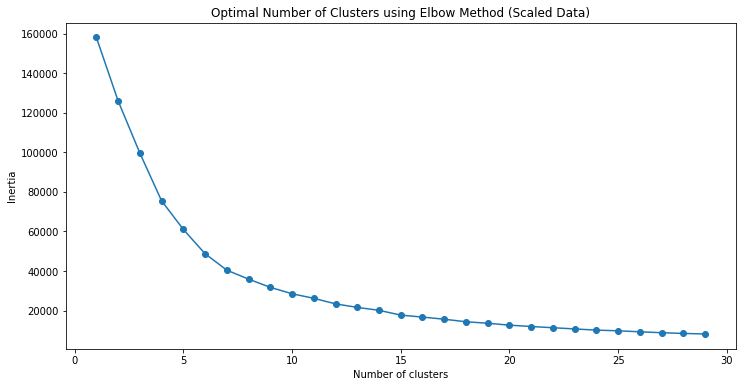

In [25]:
sse = []
k_list = range(1, 30)
for k in tqdm(k_list):
    km = KMeans(n_clusters=k)
    km.fit(book_cluster_scale)
    sse.append([k, km.inertia_])
    
oca_results_scale = pd.DataFrame({'Cluster': range(1,30), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

K = 4일때의 Silhouette Score가 더 크다!
**4**가 Optimal

In [26]:
kmeans_scale_4 = KMeans(n_clusters=4).fit(book_cluster_scale)
kmeans_scale_5 = KMeans(n_clusters=5).fit(book_cluster_scale)

print('KMeans Scaled Silhouette Score 4: {}'.format(silhouette_score(book_cluster_scale, kmeans_scale_4.labels_, metric='euclidean')))
print('KMeans Scaled Silhouette Score 5: {}'.format(silhouette_score(book_cluster_scale, kmeans_scale_5.labels_, metric='euclidean')))

KMeans Scaled Silhouette Score 3: 0.7368614034275693
KMeans Scaled Silhouette Score 4: 0.7307703169829224
KMeans Scaled Silhouette Score 5: 0.33661841545464083


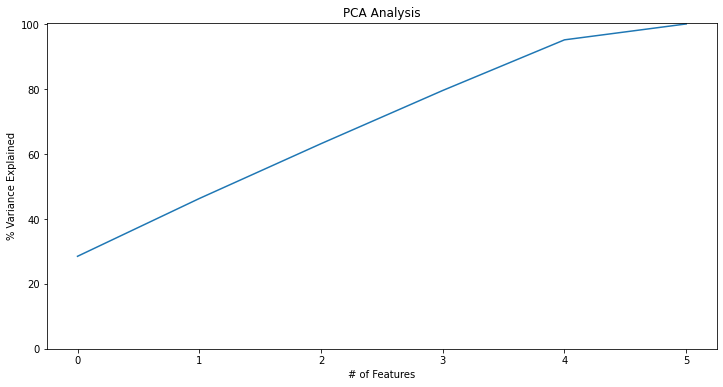

In [27]:
pca = PCA(n_components=6)
pca.fit(book_cluster_scale)
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)

In [28]:
print(var)

[ 28.5  46.3  63.2  79.6  95.2 100.1]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



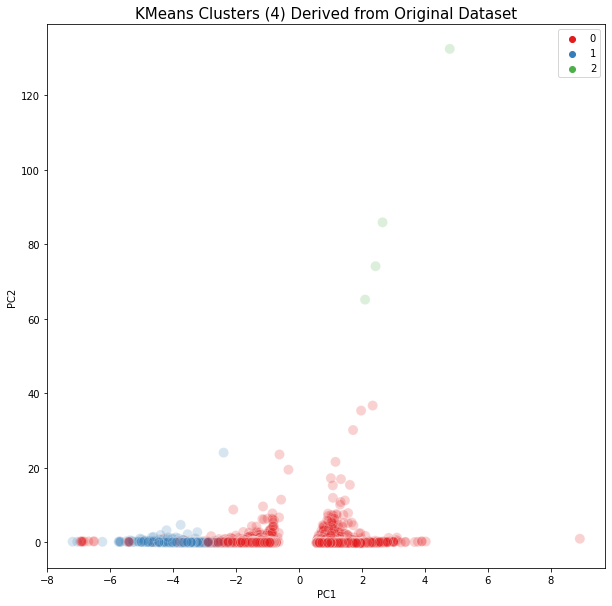

In [37]:
pca2 = PCA(n_components=3).fit(book_cluster_scale)
pca2d = pca2.transform(book_cluster_scale)
labels_scale = kmeans_scale_4.labels_

plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels_scale, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (4) Derived from Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()


In [38]:
pca2 = PCA(n_components=3).fit(book_cluster_scale)
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels_scale = kmeans_scale_4.labels_
labels = labels_scale
trace = go.Scatter3d(x=pca2d[:,0], y=pca2d[:,1], z=pca2d[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [39]:
book_cluster_scale['cluster'] = kmeans_scale_4.labels_
book_cluster_scale

,text_reviews_count,is_ebook,average_rating,num_pages,publication_year,ratings_count,cluster
0,-0.121877,-0.185827,-0.623043,-0.487189,-0.994718,-0.036482,0
1,-0.114011,-0.185827,-0.623043,-0.266829,0.109694,-0.032611,0
2,-0.035349,-0.185827,-0.928508,0.017803,-0.330345,-0.023732,0
3,-0.098278,-0.185827,2.355241,-0.312737,0.109694,-0.035799,0
4,-0.121877,-0.185827,0.038798,-0.266829,0.126951,-0.036368,0
...,...,...,...,...,...,...,...
26329,-0.114011,-0.185827,2.075231,-0.450462,0.118322,-0.035799,0
26330,-0.121877,-0.185827,-1.641260,-0.560642,-0.157781,-0.035230,0
26331,-0.082546,-0.185827,-1.513982,-0.413735,-0.011101,-0.032498,0
26332,-0.058947,-0.185827,0.038798,-0.427508,-0.175037,-0.030562,0


#### cluster 분포 확인 : 잘 되지 않았음을 알 수 있다.

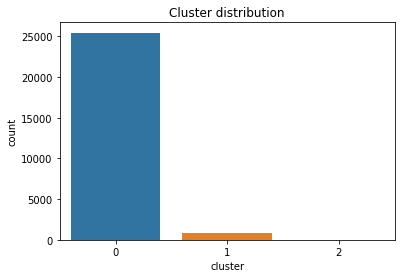

In [40]:
sns.countplot(x="cluster", data=book_cluster_scale)
plt.title("Cluster distribution")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



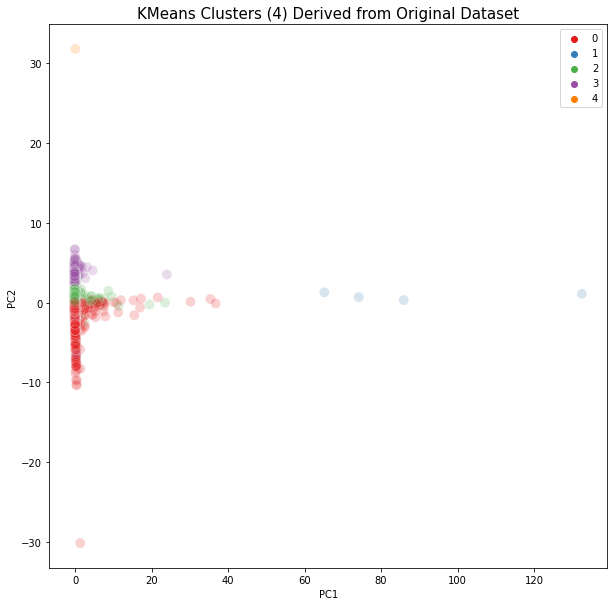

In [41]:
pca2 = PCA(n_components=3).fit(book_cluster_scale)
pca2d = pca2.transform(book_cluster_scale)
labels_scale = kmeans_scale_5.labels_

plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels_scale, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (4) Derived from Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [42]:
pca2 = PCA(n_components=3).fit(book_cluster_scale)
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels_scale = kmeans_scale_5.labels_
labels = labels_scale
trace = go.Scatter3d(x=pca2d[:,0], y=pca2d[:,1], z=pca2d[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [43]:
book_cluster_scale['cluster'] = kmeans_scale_5.labels_
book_cluster_scale

,text_reviews_count,is_ebook,average_rating,num_pages,publication_year,ratings_count,cluster
0,-0.121877,-0.185827,-0.623043,-0.487189,-0.994718,-0.036482,2
1,-0.114011,-0.185827,-0.623043,-0.266829,0.109694,-0.032611,2
2,-0.035349,-0.185827,-0.928508,0.017803,-0.330345,-0.023732,2
3,-0.098278,-0.185827,2.355241,-0.312737,0.109694,-0.035799,0
4,-0.121877,-0.185827,0.038798,-0.266829,0.126951,-0.036368,0
...,...,...,...,...,...,...,...
26329,-0.114011,-0.185827,2.075231,-0.450462,0.118322,-0.035799,0
26330,-0.121877,-0.185827,-1.641260,-0.560642,-0.157781,-0.035230,2
26331,-0.082546,-0.185827,-1.513982,-0.413735,-0.011101,-0.032498,2
26332,-0.058947,-0.185827,0.038798,-0.427508,-0.175037,-0.030562,0


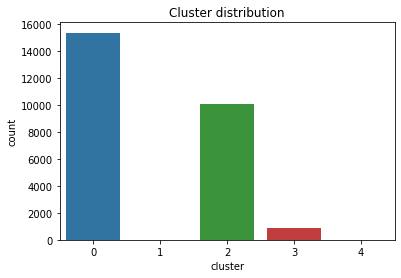

In [44]:
sns.countplot(x="cluster", data=book_cluster_scale)
plt.title("Cluster distribution")
plt.show()

단순 실루엣 계수만 확인하지 말고 실루엣 다이어 그램을 그려보기. PCA = 4일 때도 확인해보기!